# Conditional Mixture Models:
## Linear Regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from numpy.linalg import inv
from numpy.random import randn, rand, seed

In [2]:
%config InlineBackend.figure_format = "retina"

Consider $K$ linear regression models in the real line ($f_k: \mathbb{R}^M\to\mathbb{R}$), each governed by its own weight vector ${\bf w}_k$ and sharing the same precision parameter $\beta$. To make a **mixture of linear regressions**, we consider a set of weighting coefficients $\{\pi_k\}_k$ and a mixture distribution given by

$$
    p({\bf t}\vert \boldsymbol\theta,\boldsymbol\phi) = \sum_{k=1}^K \pi_k \mathcal{N}(t_n\vert{\bf w}_k^T\boldsymbol\phi, \beta^{-1})
$$

Where $\boldsymbol\theta=\big\{\{{\bf w}_k\}_k, \{\pi_k\}_k, \beta\big\}$

In order to find the values of $\boldsymbol\theta$, we make use of th EM algorithm by introducing latent variables ${\bf Z}=\{{\bf z}_n\}_n$. The EM algorithm then turns in finding the coefficients

$$
\gamma_{nk} = \frac{\pi_k\mathcal{N}(t_n\vert{\bf w}_k^T\boldsymbol\phi_n, \beta^{-1})}{\sum_j\pi_j\mathcal{N}(t_n\vert{\bf w}_j^T\boldsymbol\phi_n, \beta^{-1})}
$$

for the **E-step**, and maximizing

$$
Q(\boldsymbol\theta, \boldsymbol\theta^{\text{old}}) = \sum_{n=1}^N\sum_{k=1}^K \gamma_{nk}\big[\log\pi_k + \log\mathcal{N}(t_n\vert{\bf w}_k^T\boldsymbol\phi, \beta^{-1})\big]
$$

w.r.t. each component of $\boldsymbol\theta$ for the **M-step**.

The M-step results in the updating equations:

$$
\pi_k^\text{new} = \frac{1}{N}\sum_{n=1}^N\gamma_{nk}
$$

$$
{\bf w}_k^\text{new} = \left(\boldsymbol\Phi^T R_k\boldsymbol\Phi\right)^{-1}\boldsymbol\Phi R_k {\bf t}
$$

$$
\frac{1}{\beta^\text{new}} = \frac{1}{N}\sum_{n=1}^N\sum_{k=1}^K \gamma_{nk}[t_n - {\bf w}_k^T\boldsymbol\phi_n]
$$

With
* $R_k = \text{diag}(\gamma_{1k}, \ldots, \gamma_{Nk})$
* $\boldsymbol\Phi\in\mathbb{R}^{N\times M}$
* ${\bf t}\in\mathbb{R}^{N}$
* ${\bf w}_k\in\mathbb{R}^{M}$

## An example

In [3]:
seed(314)
n_obs = 21
xrange = np.linspace(-1, 1, n_obs) + rand(n_obs) * 0.1

n_vals = n_obs // 3
phi = np.c_[np.ones(n_obs), xrange]
z = np.ones((n_obs, 2))
z[n_vals: 2 *  n_vals, 0] = 0
z[:, 1] = z[:, 1]- z[:, 0]
# MxK
w_true = np.array([
    [-0.9, 0.7],
    [0.2, 0.5]
])

beta_true = 1 / 0.1
t_complete = np.einsum("nm,nk,mk->nk", phi, z, w_true)
t = t_complete.sum(axis=1) + randn(n_obs) / beta_true

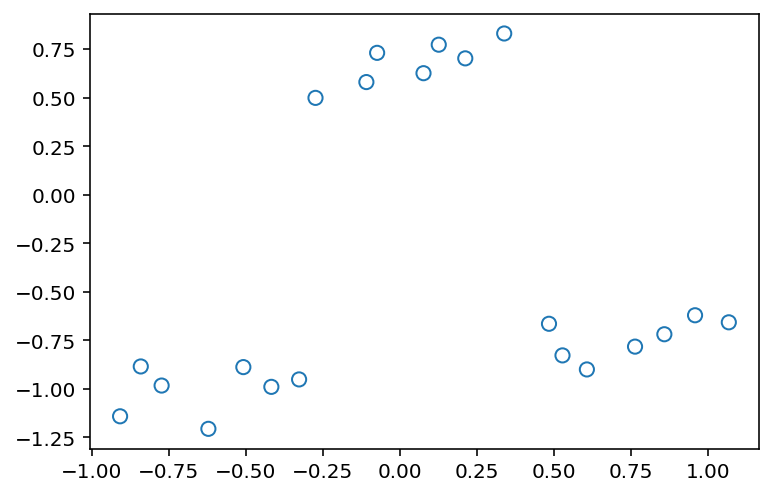

In [4]:
plt.scatter(xrange, t, facecolors="none", edgecolors="tab:blue", s=50)

In [5]:
xplot = np.linspace(-1, 1, 200)
phi_plot = np.c_[np.ones_like(xplot), xplot]

In [6]:
# parameter initializiation
seed(314)
w_em = randn(2, 2)
beta_em = beta_true
pi_em = rand(2)
pi_em = pi_em / pi_em.sum()
# auxiliary latent vector
z_em = np.ones((n_obs, 2))

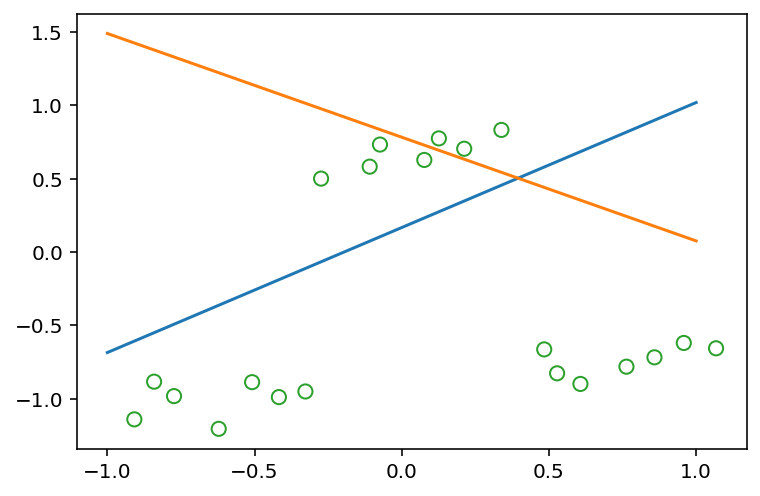

In [7]:
t_plot = np.einsum("nm,mk->nk", phi_plot, w_em)
plt.scatter(xrange, t, facecolors="none", edgecolors="tab:green", s=50)
plt.plot(xplot, t_plot);

In [8]:
# mu_values
mus_em = np.einsum("nm,mk->nk", phi, w_em)
N_vals = norm(loc=mus_em, scale=1/beta_em).pdf(t[:, None])
gamma_nk = N_vals / N_vals.sum(axis=1, keepdims=True)

In [9]:
# Pi update
pi_em = gamma_nk.mean(axis=0)
pi_em

array([0.33630629, 0.66369371])

In [10]:
# w update
Rk = np.einsum("nl,nk->knl", np.eye(n_obs), gamma_nk)
w_em = inv(np.einsum("nm,knl,no->kmo", phi, Rk, phi))
w_em = np.einsum("kmo,no,knl,n->mk", w_em, phi, Rk, t)
w_em

array([[-0.73915004,  0.53619389],
       [ 0.40527649, -1.43197476]])

In [11]:
beta_inv = gamma_nk * (mus_em - t[:, None]) ** 2
beta_em = n_obs / beta_inv.sum() 
beta_em

1.9701166052645216

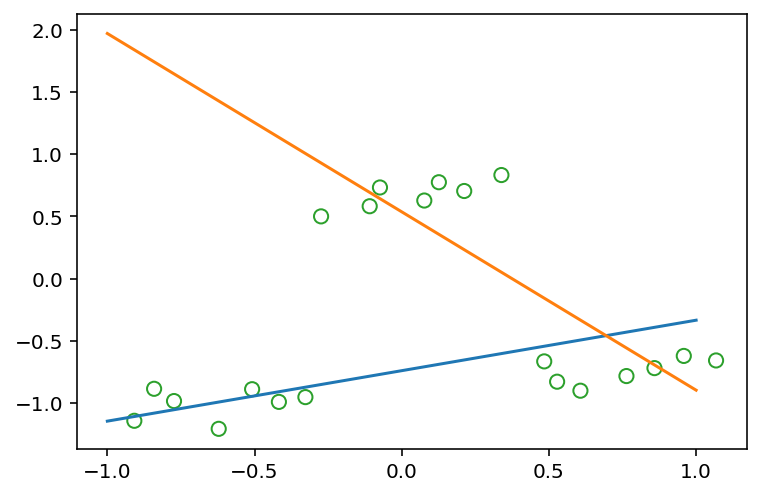

In [12]:
t_plot = np.einsum("nm,mk->nk", phi_plot, w_em)
plt.scatter(xrange, t, facecolors="none", edgecolors="tab:green", s=50)
plt.plot(xplot, t_plot);

## All together

In [13]:
def e_step(phi, t, w, beta):
    # mu_values
    mus_em = np.einsum("nm,mk->nk", phi, w)
    N_vals = norm(loc=mus_em, scale=1/beta).pdf(t[:, None])
    gamma_nk = N_vals / N_vals.sum(axis=1, keepdims=True)
    return gamma_nk

def m_step(phi, t, gamma_nk):
    N, K = gamma_nk.shape
    # pi-update
    pi = gamma_nk.mean(axis=0)
    # weights-update
    Rk = np.einsum("nl,nk->knl", np.eye(N), gamma_nk)
    w = inv(np.einsum("nm,knl,no->kmo", phi, Rk, phi))
    w = np.einsum("kmo,no,knl,n->mk", w, phi, Rk, t)
    # precision-update
    mus_em = np.einsum("nm,mk->nk", phi, w)
    beta_inv = gamma_nk * (mus_em - t[:, None]) ** 2
    beta = N / beta_inv.sum() 
    
    return pi, w, beta

In [14]:
# parameter initializiation
seed(314)
w_em = randn(2, 2)
beta_em = 1
pi_em = rand(2)
pi_em = pi_em / pi_em.sum()
# auxiliary latent vector
z_em = np.ones((n_obs, 2))
gamma_nk = e_step(phi, t, w_em, beta_em)

hist_responsibilities = [gamma_nk]
hist_weights = [w_em]
for _ in range(7):
    gamma_nk = e_step(phi, t, w_em, beta_em)
    pi_em, w_em, beta_em = m_step(phi, t, gamma_nk)
    hist_responsibilities.append(gamma_nk)
    hist_weights.append(w_em)

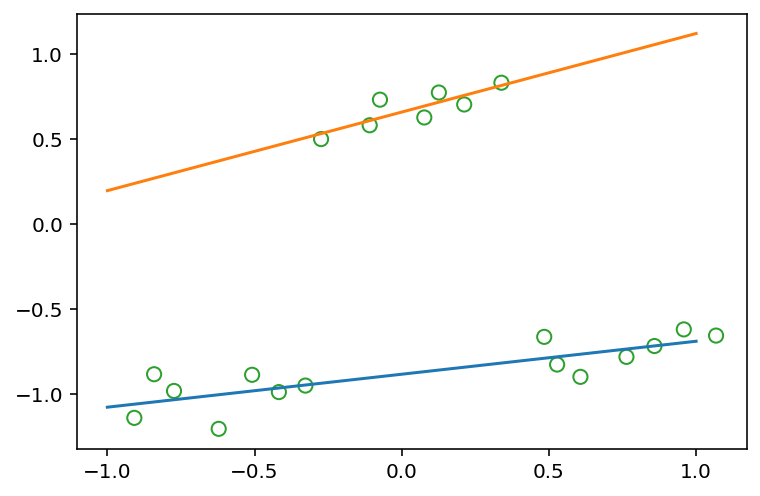

In [15]:
t_plot = np.einsum("nm,mk->nk", phi_plot, w_em)
plt.scatter(xrange, t, facecolors="none", edgecolors="tab:green", s=50)
plt.plot(xplot, t_plot);

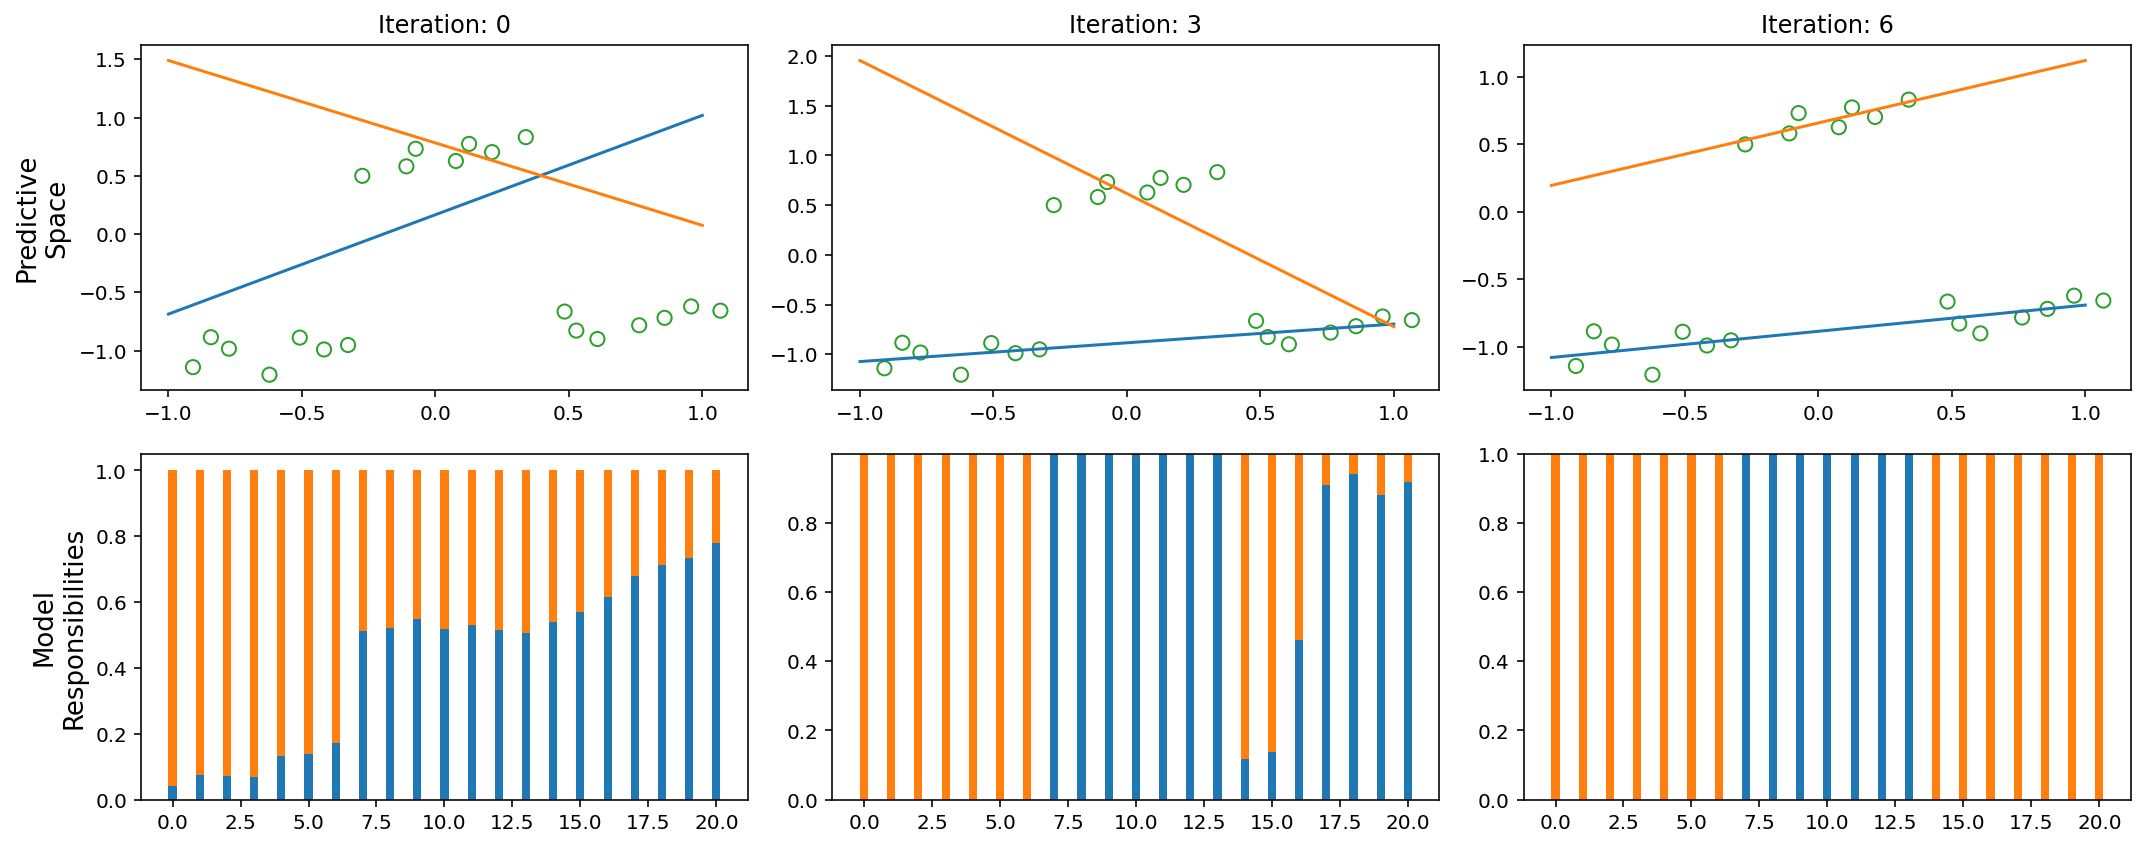

In [16]:
fig, ax = plt.subplots(2, 3, figsize=(15, 6))
ax = ax.T
its = [0, 3, 6]

for it, axi in zip(its, ax):
    axi_1, axi_2 = axi
    x_resp = np.arange(n_obs)
    resp = hist_responsibilities[it]
    w = hist_weights[it]
    t_plot = np.einsum("nm,mk->nk", phi_plot, w)
    axi_1.scatter(xrange, t, facecolors="none", edgecolors="tab:green", s=50)
    axi_1.plot(xplot, t_plot);
    axi_1.set_title(f"Iteration: {it}")
    axi_2.bar(x_resp, resp[:, 1], width=0.3)
    axi_2.bar(x_resp, resp[:, 0], bottom=resp[:, 1], width=0.3)
ax[0, 0].set_ylabel("Predictive\nSpace", fontsize=13)
ax[0, 1].set_ylabel("Model\nResponsibilities", fontsize=13)
plt.tight_layout()